In [17]:
import casadi as ca
import numpy as np
import math
import control as ct
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

We use a NED frame with **intrinsic** Y-P-R rotations ${}^{I}R_{B}=R_{\psi}R_{\theta}R_{\phi}$ with body frame and inertial frames aligned when there is **no rotation**.

$$
\begin{align}
m\ddot{X} &= -F(\cos{\phi}\sin{\theta}\cos{\psi}+\sin{\phi}\sin{\psi}) \\
m\ddot{Y} &= -F(\cos{\phi}\sin{\theta}\sin{\psi}-\sin{\phi}\cos{\psi}) \\
m\ddot{Z} &= -F(\cos{\phi}\cos{\theta})+mg \\
I_{x}\ddot{\phi} &= T_{x}l+\dot{\theta}\dot{\psi}(I_{y}-I_{z}) \\
I_{y}\ddot{\theta} &= T_{y}l+\dot{\psi}\dot{\phi}(I_{z}-I_{x}) \\
I_{z}\ddot{\psi} &= T_{z}l+\dot{\phi}\dot{\theta}(I_{x}-I_{y}) \\
F & = F_1 + F_2 + F_3 + F_4
\end{align}
$$

Our LQR gain matrix uses the following:

Max errors for each variable
- $x$: 1e-6
- $y$: 1e-6
- $z$: +-20m max so (1/20**2) = 0.0025
- $\phi,(\text{roll})$: +-$\pi$ so (1/$\pi^{2}$)
- $\theta,(\text{pitch})$: +-$\frac{\pi}{2}$ so 1/$(\frac{\pi}{2})^{2}$
- $\psi,(\text{yaw})$: +-$\pi$ so (1/$\pi^{2}$) - might actually want to increase more so we don't penalise yaw as much
- $\dot{x}$: 1e-6
- $\dot{y}$: 1e-6
- $\dot{z}$: +-5m/s max so (1/5**2) = 0.04
- $\dot{\phi}$: +-$\frac{\pi}{2}$rad/s max so 1/$(\frac{\pi}{2})^{2}$
- $\dot{\theta}$: +-$\frac{\pi}{2}$rad/s max so 1/$(\frac{\pi}{2})^{2}$
- $\dot{\psi}$: +-$\frac{\pi}{4}$rad/s max so 1/$(\frac{\pi}{4})^{2}$

In [56]:
x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

#m = 1
m = 2.43  # kg
g = 9.81  # m/s^2
#Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
#Ix, Iy, Iz = 0.0035, 0.0035, 0.005  # kg m^2
Ix, Iy, Iz = 0.008, 0.015, 0.017  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)
dt=0.01 ## Simulate step at 100Hz

parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi
dx_dx = -(u_F/m) * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = -(u_F/m) * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi) - ca.sin(x_phi)*ca.cos(x_psi))
dx_dz = -(u_F/m) * (ca.cos(x_phi) * ca.cos(x_theta)) + g
dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

## Apply 25N of force for 10 seconds
out = [0, 0, -20, 0.2, 0.2, 0, 0, 0, 0, 0, 0, 0]
u_in = [25, 0, 0, 0]
for i in range(0,1000):
    out = dynamics(out, u_in)
print(f"State after 10s: {out}")

assert(out[0]<0) ## Negative x-coordinate with +ve pitch
assert(out[1]>0) ## Positive y-coordinate with +ve roll
assert(out[2]<0) ## Negative z-coordinate with positive net Force in NED frame

## Linearization
x_operating = np.zeros((12, 1))
u_operating = np.array([m*g, 0, 0, 0]).reshape((-1, 1))  # hovering (mg 0 0 0)

A = ca.Function("A", [x, u], [ca.jacobian(f, x)])(x_operating, u_operating)
B = ca.Function("B", [x, u], [ca.jacobian(f, u)])(x_operating, u_operating)
C = np.eye(12)
D = np.zeros((12, 4))

#make numerical matrices and cast into numpy array
A = np.array(ca.DM(A))
B = np.array(ca.DM(B))

lin_ss_cont = ct.ss(A,B,C,D)
lin_ss_disc = ct.c2d(lin_ss_cont,dt,method='zoh')

## LQR and riccati equation
#Q = np.diag([1e-9, 1e-9, 1/(20**2), 1, 1, 1, 1e-9, 1e-9, 0.05, 0.1,0.1,0.1])
#Q = np.diag([1e-3, 1e-3, 1/(20**2), 1, 1, 1, 1e-9, 1e-9, 0.05, 0.1,0.1,0.1])
'''
Q = np.diag([1e-6, 1e-6,1/(20**2),
             1/(math.pi**2), 1/((math.pi/2)**2), 1/(math.pi**2),
             1e-6, 1e-6, (1/5**2),
             1/((math.pi/2)**2), 1/((math.pi/2)**2), 1/((math.pi/4)**2)])
'''
Q = np.diag([1/(1**2), 1/(1**2),1/(20**2),
             1/(math.pi**2), 1/((math.pi/2)**2), 1/((math.pi/2)**2),
             1/(0.5**2), 1/(0.5**2), (1/5**2),
             1/((math.pi/2)**2), 1/((math.pi/2)**2), 1/((math.pi/4)**2)])

R = np.diag([0.05, 5, 5, 5])

lqr_k, _, _ = ct.lqr(A,B,Q,R)
for i in range(0,4):
    for j in range(0,12):
        if abs(lqr_k[i,j]) < 1e-6:
            lqr_k[i,j]=0
        print(f"{lqr_k[i,j]:+6.4f} ", end='')
    print()
#print(f"LQR Gains: {lqr_k}")

State after 10s: [-100.059, 102.094, -23.5964, 0.2, 0.2, 0, -20.0318, 20.4392, -0.72001, 0, 0, 0]
+0.0000 +0.0000 -0.2236 +0.0000 +0.0000 +0.0000 +0.0000 +0.0000 -1.3736 +0.0000 +0.0000 +0.0000 
+0.0000 +0.4472 +0.0000 +2.6419 +0.0000 +0.0000 +0.0000 +1.0202 +0.0000 +0.3512 +0.0000 +0.0000 
-0.4472 +0.0000 +0.0000 +0.0000 +2.8652 +0.0000 -1.0302 +0.0000 +0.0000 +0.0000 +0.4087 +0.0000 
+0.0000 +0.0000 +0.0000 +0.0000 +0.0000 +0.2847 +0.0000 +0.0000 +0.0000 +0.0000 +0.0000 +0.5778 


In [57]:
## Simulation Setup
#iterations = 10*100
iterations=1000

dt = 0.01
x_bag = np.zeros((12, iterations))
time = np.linspace(0,1,100)

temp_x = [0, 0, 10, 0.1, 0, -0.1, 0, 0, 0, 0, 0, 0]
temp_u = [0, 0, 0, 0]

## Control variables

# Destination (NED frame, metres)
target_x = 50
target_y = 50
target_z = -20 ## Indicates 20 metres above "ground" or "0 alt"
target_yaw = 0 ## No yawing required for our waypoint controller

## Reset all PID controllers
'''
for c in controller_array:
    c.reset()
    c.reset_logging()
'''

## Intermediate variables that we want to plot
ctx = {
    'c_roll_out': [],
    'c_pitch_out': [],
    'c_yaw_out': [],
    'c_throttle_out': [],
    'mot_0': [],
    'mot_1': [],
    'mot_2': [],
    'mot_3': [],
    'u_force': [],
    'u_rtorque': [],
    'u_ptorque': [],
    'u_ytorque': []
}

desired_roll = 0
desired_pitch = 0

## 1 second simulation
for j in range(0,iterations):

    '''
    ## 2. Run controller (at 100Hz)
    if j%4==0:
        desired_rate_roll = pi_stabilize_roll(desired_roll, temp_x[3], dt)
    desired_rate_pitch = pi_stabilize_pitch(desired_pitch, temp_x[4], dt)

    if j%4==0:
        rroll_output = pid_rate_roll(desired_rate_roll, temp_x[9], dt)
    rpitch_output = pid_rate_pitch(desired_rate_pitch, temp_x[10], dt)

    ## YAW Control
    # Limit the error to be between +-pi/4

    if target_yaw - temp_x[5] > math.pi/4:
        target_yaw = temp_x[5] + math.pi/4
    elif target_yaw - temp_x[5] < math.pi/4:
        target_yaw = temp_x[5] - math.pi/4
        
    ryaw_output = pi_stabilize_yaw(target_yaw, temp_x[5], dt)
    
    ## THROTTLE Control
    rthrottle_output = pi_alt_throttle(target_z, temp_x[2], dt)
    '''

    ## 4. Convert to input (force and torques) and feed to dynamics (via temp_u)
    ## NOTE allocations should each be in range [1230, 1900] and we collectively convert to a force/torque

    ## Add the reference **to a copy**
    new_tx = temp_x.copy()
    new_tx[2] -= target_z
    #new_tx[3] -= 1 ## Target roll
    
    lqr_out = -lqr_k@new_tx
    
    '''
    temp_u = [-10-rthrottle_output,
              rroll_output,
              rpitch_output,
              ryaw_output]
    '''
    temp_u = [m*g+lqr_out[0], lqr_out[1], lqr_out[2], lqr_out[3]]
    
    ## Constrain force between [0,20] : 0 is no throttle and 20 is full throttle
    if temp_u[0]<0:
        temp_u[0]=0
    elif temp_u[0]>50:
        temp_u[0]=50
    
    # Store intermediate variables
    ctx['u_force'].append(temp_u[0])
    ctx['u_rtorque'].append(temp_u[1])
    ctx['u_ptorque'].append(temp_u[2])
    ctx['u_ytorque'].append(temp_u[3])

    # Feed dynamics
    temp_x = dynamics(temp_x, temp_u).full()

    # Wrap roll/pitch/yaw
    ## TODO

    # Record output for plotting
    x_bag[:, j] = temp_x.reshape((12,))
    temp_x = temp_x.reshape((12,))

print(temp_x, temp_u)

[-1.01171040e-07  2.87728924e-04 -1.51426727e+01  7.65753149e-06
  1.09995676e-08 -6.74919814e-04  7.05894348e-08 -1.44626595e-04
 -1.32212882e+00 -3.90056845e-06 -1.02869859e-08  3.37497521e-04] [np.float64(23.107208842242965), np.float64(1.5988903364895458e-08), np.float64(1.630722523029207e-10), np.float64(-2.883467627881885e-06)]


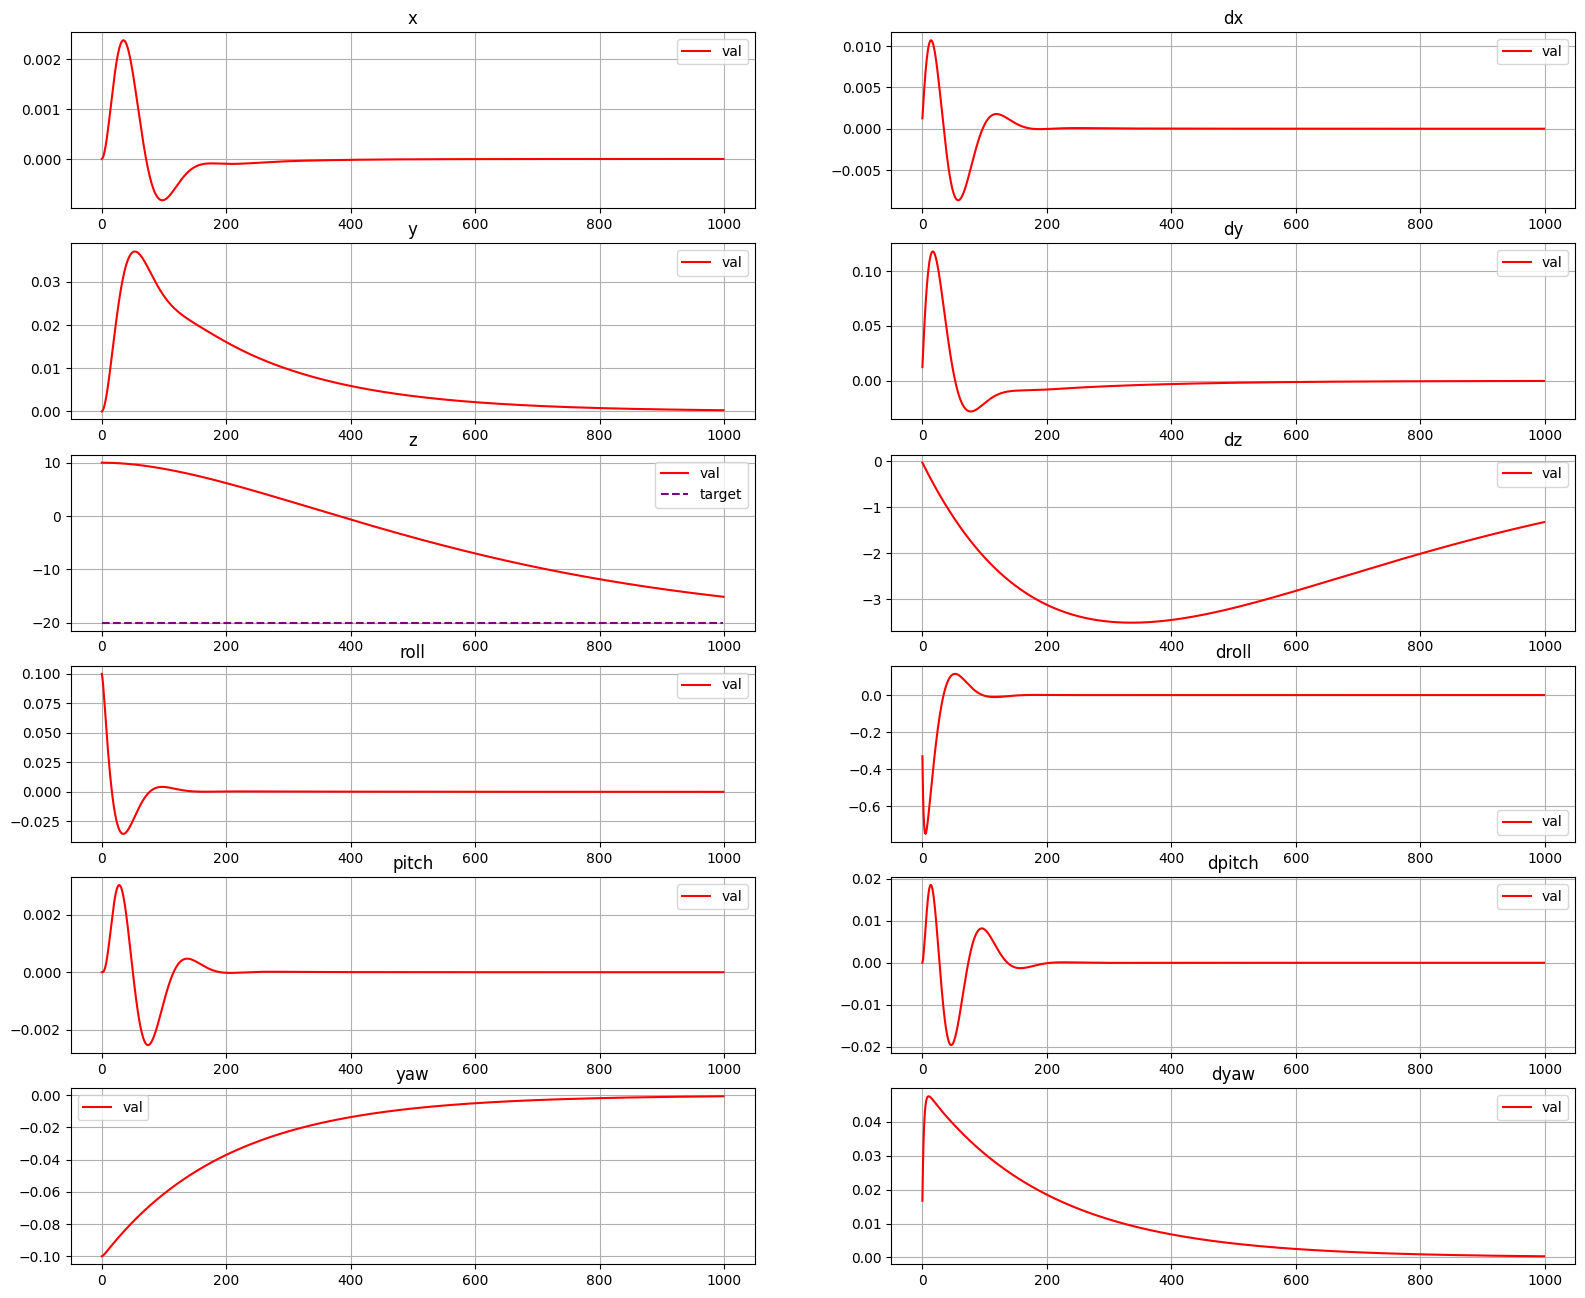

In [58]:
# Visualisation - State Variables
fig = plt.figure(figsize=(30, 16))
gs = GridSpec(6, 3, figure=fig)

for i,title in enumerate(['x','y','z','roll','pitch','yaw','dx','dy','dz','droll','dpitch','dyaw']):
    ax = fig.add_subplot(gs[i%6,i//6])
    t = range(0,x_bag[i,:].shape[0])
    ax.plot(t, x_bag[i,:], color='red', label='val')
    if title=='z':
        ax.plot(t, len(t)*[-20], color='purple', linestyle='--', label='target')
    ax.set_title(title)
    ax.grid()
    ax.legend()

plt.show()

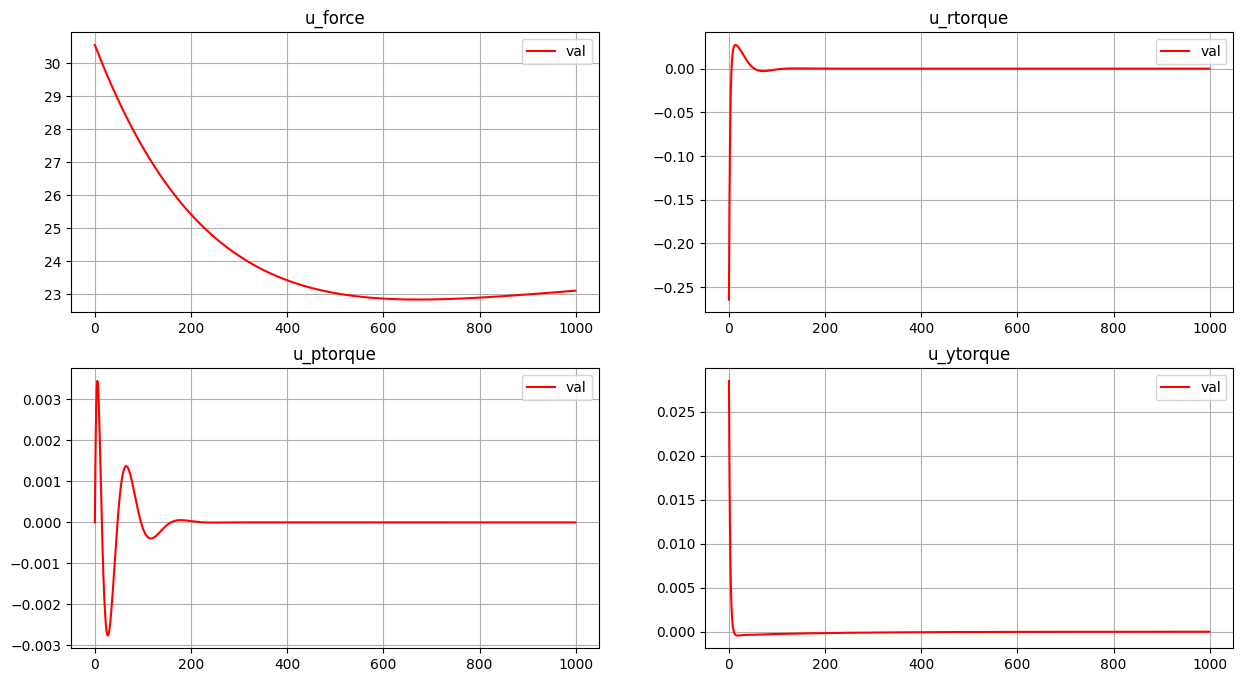

In [60]:
# Visualisation - State Variables
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 2, figure=fig)

for i,title in enumerate(['u_force', 'u_rtorque', 'u_ptorque', 'u_ytorque']):
    ax = fig.add_subplot(gs[i//2, i%2])
    t = range(0,len(ctx[title]))
    ax.plot(t, ctx[title], color='red', label='val')
    if title=='z':
        ax.plot(t, len(t)*[-20], color='purple', linestyle='--', label='target')
    ax.set_title(title)
    ax.grid()
    ax.legend()

plt.show()

### Mixer Solution

$$F=mg=4k_{t}\omega_{i}^{2}\$$

In [66]:
## NOTE We have updated the kt parameter as we were using the incorrect equation to calculate
#kt = 2.3e-6
kt = 2.08e-5
#kt = 1.15e-5
km = 0.02*kt
ylen = 0.22
xlen = 0.13
preinv = np.array([[kt, kt, kt, kt],
                  [-ylen*kt, ylen*kt, -ylen*kt, ylen*kt],
                  [xlen*kt, -xlen*kt, -xlen*kt, xlen*kt],
                  [km, km, -km, -km]])

allocation = np.linalg.pinv(preinv)
print(allocation)
print(kt)
print(km)

mixer_sol = np.sqrt(allocation @ np.array([ctx['u_force'],
          ctx['u_rtorque'],
          ctx['u_ptorque'],
          ctx['u_ytorque']]))

## With a 1kg mass, we need approx 1082rad/s rotor speeds for hover, but we use a different mass in our model m=2.43

mass = 2.43
print()
print(f"MG: {mass*9.81}")
print(f"omega: {math.sqrt(mass*g/(4*kt))}")
print(1000+1000*(535/2000))

print(mass*g/(4*535*535))
print(f"NEW KT ESTIMATE: {mass*g/(4*720*720)}")

rotor_vel_hover = math.sqrt(mass*g/(4*kt))
print(f"Rotor Vel Hover: {rotor_vel_hover}")

[[  12019.23076923  -54632.86713287   92455.62130178  600961.53846154]
 [  12019.23076923   54632.86713287  -92455.62130178  600961.53846154]
 [  12019.23076923  -54632.86713287  -92455.62130178 -600961.53846154]
 [  12019.23076923   54632.86713287   92455.62130178 -600961.53846154]]
2.08e-05
4.16e-07

MG: 23.838300000000004
omega: 535.2737886784238
1267.5
2.0821294436195304e-05
NEW KT ESTIMATE: 1.1496093750000001e-05
Rotor Vel Hover: 535.2737886784238


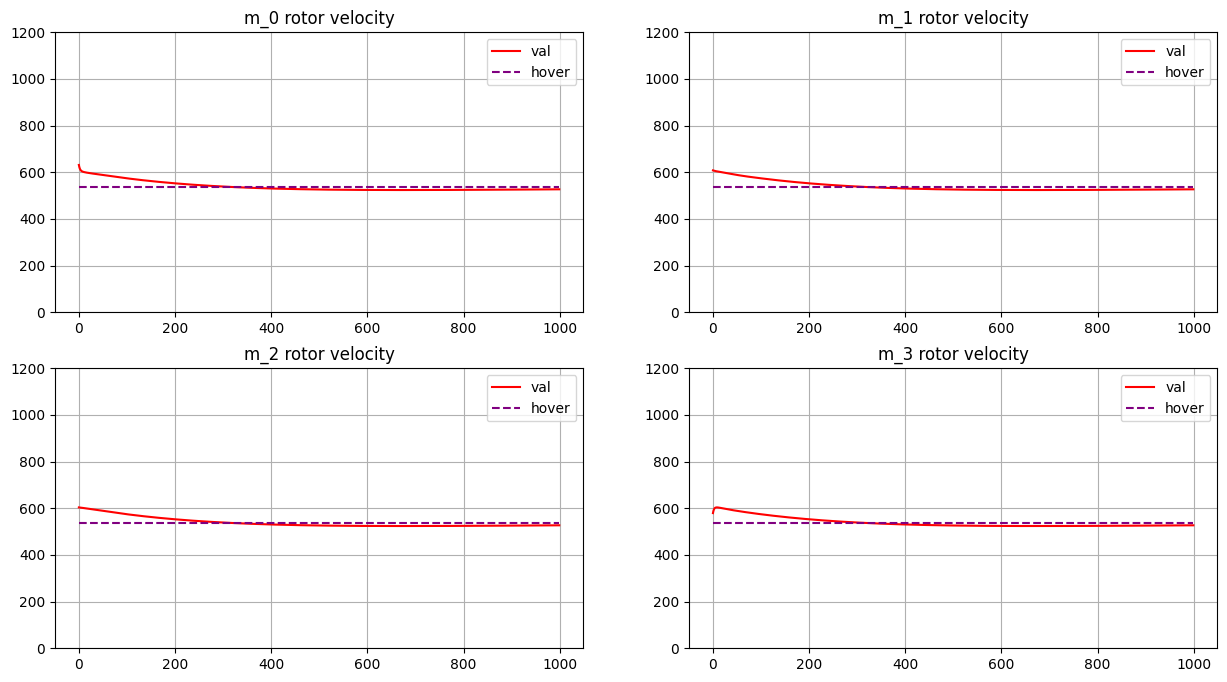

In [68]:
# Visualisation - State Variables
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 2, figure=fig)

for i,title in enumerate(['m_0', 'm_1', 'm_2', 'm_3']):
    ax = fig.add_subplot(gs[i//2, i%2])
    t = range(0,len(mixer_sol[i,:]))
    ax.plot(t, mixer_sol[i,:], color='red', label='val')
    ax.set_title(title + ' rotor velocity')
    ax.grid()
    ax.set_ylim(0,1200)
    ax.plot(t, len(t)*[535], linestyle='--', color='purple', label='hover')
    ax.legend()

plt.show()

In [15]:

vec = [1268, 1290, 1312, 1312]

for e in vec:
    print(2000*(e-1000)/1000)

536.0
580.0
624.0
624.0
